This notebook generates docking score dataset from CrossDock 100k

In [35]:
import sys
sys.path.append('../')

import torch
from glob import glob
from tqdm import tqdm

from src.tacogfn.utils.molecules import sdf_to_single_smiles
from src.tacogfn.data.pharmacophore import PharmacoDB

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')

Load type files containing all information

In [36]:
files = glob('../dataset/it2_tt_v1.1_completeset_train0.types')

In [37]:
def process_line(line):
    info = line.split()
    pocket_id = info[3].split("/")[-1].split('_rec')[0] 
    ligand_id = info[4].split("/")[-1].split('rec_')[1].split('_lig')[0] 
    docking_score = float(info[-1][1:])
    return pocket_id, ligand_id, docking_score

Create a dataset with docking score (key is pocket_id + '_' + ligand_id)

In [38]:
dataset = {}

for file_path in files:
    with open(file_path, "r") as file:
        for line in tqdm(file):
            pocket_id, ligand_id, docking_score = process_line(line)
            key = pocket_id + '_' + ligand_id
            if key not in dataset:
                dataset[key] = [docking_score]        
            else:
                dataset[key].append(docking_score)

22583743it [00:31, 717704.51it/s]


In [39]:
# for file_path in files:
#     with open(file_path, "r") as file:
#         for line in file:
#             key = '3rlj_A_rec_1i38_dht'
#             if key in line:
#                 print(line)

We can only use a subset of this dataset

In [40]:
splits = torch.load('../dataset/split_by_name.pt')

In [41]:
get_pocket_id_and_ligand_id = lambda path: (path.split('/')[1].split('_rec')[0], path.split('/')[1].split('rec_')[1].split('_lig')[0])

In [42]:
train_pairs = [get_pocket_id_and_ligand_id(path) for path, _ in splits['train']]
train_keys = set(pair[0] + '_' + pair[1] for pair in train_pairs)

test_pairs = [get_pocket_id_and_ligand_id(path) for path, _ in splits['test']] 
test_keys = set(pair[0] + '_' + pair[1] for pair in test_pairs)

In [43]:
train_dataset = {key: dataset[key] for key in dataset.keys() if key in train_keys}
test_dataset = {key: dataset[key] for key in dataset.keys() if key in test_keys}

In [44]:
print('There are {} ligand pocket combinations in CrossDock 100k'.format(len(train_keys)))
print('There are {} ligand pocket combinations in CrossDock 100k'.format(len(test_keys)))

There are 84459 ligand pocket combinations in CrossDock 100k
There are 100 ligand pocket combinations in CrossDock 100k


In [45]:
len(train_dataset), len(test_dataset)
print('There are {} ligand pocket combinations in train with docking score'.format(len(train_dataset)))
print('There are {} ligand pocket combinations in test with docking score'.format(len(test_dataset)))

There are 84459 ligand pocket combinations in train with docking score
There are 100 ligand pocket combinations in test with docking score


We average the top docking scores for each protein ligand pair as label

In [46]:
acc_train_dataset = {
    key: min(scores + [0]) for key, scores in train_dataset.items()
}
acc_test_dataset = {
    key: min(scores + [0]) for key, scores in test_dataset.items()
}

Distribution of docking scores

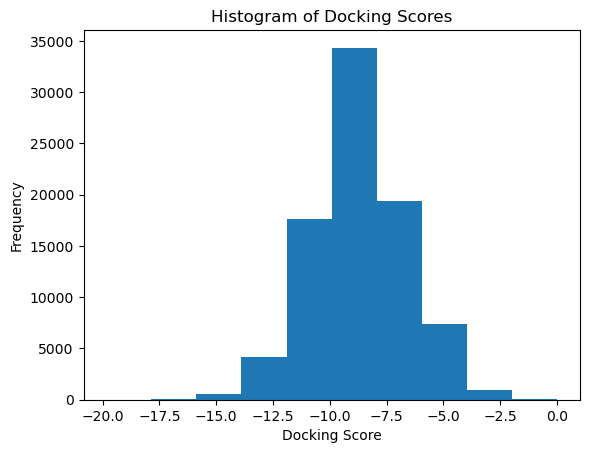

In [47]:
import matplotlib.pyplot as plt

docking_scores = acc_train_dataset.values()

plt.hist(docking_scores, bins=10)
plt.xlabel('Docking Score')
plt.ylabel('Frequency')
plt.title('Histogram of Docking Scores')
plt.show()

In [48]:
from statistics import mean

avg = mean(list(docking_scores))

mean([abs(score - avg) for score in docking_scores])

1.593823870220958

Get dataset in the form of (pdb_id, smiles, docking scores) 

In [88]:
import os

db = PharmacoDB('../misc/pharmacophores_db.lmdb')
avail_keys = set(db.get_keys())

dataset_with_sdf_path = []

def get_final_dataset(acc_dataset):
    final_dataset = []

    for key, score in tqdm(acc_dataset.items()):
        pdb_id = '_'.join(key.split('_')[:2])
        sdf_path = os.path.join('../dataset/crossdock', '_'.join(key.split('_')[2:]) + '_lig.sdf')
        
        try:
            smiles = sdf_to_single_smiles(sdf_path)
            
            if pdb_id in avail_keys and smiles is not None:
                if len(db.get_pharmacophore(pdb_id).nodes) >= 3:
                    final_dataset.append(
                        (pdb_id, smiles, score)
                    )
                    dataset_with_sdf_path.append(
                        (pdb_id, sdf_path, score)
                    )
        except:
            pass
    return final_dataset, dataset_with_sdf_path

In [89]:
final_train_dataset,final_train_dataset_sdf_path = get_final_dataset(acc_train_dataset)
final_test_dataset,final_test_dataset_sdf_path = get_final_dataset(acc_test_dataset)

  0%|          | 0/84459 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 176.47it/s]


In [90]:
torch.save(final_train_dataset_sdf_path, '../dataset/crossdock_docking_scores/train_with_sdf_path.pt')

In [54]:
all_smiles = [smi for smi in list(set([data[1] for data in final_train_dataset]))]
all_pdb_ids = list(set([data[0] for data in final_train_dataset]))
print('There are {} unique ligands'.format( len(all_smiles)))
print('There are {} unique pdb ids'.format( len(all_pdb_ids)))

There are 8022 unique ligands
There are 14967 unique pdb ids


Split the dataset with MOOD considerations (This only has to be done once)
Perimeter splitting is the best

In [55]:
# gflownet_molecules = [data[1] for data in torch.load('../misc/examples_of_gflownet_produced_molecules.pt')]

In [56]:
# import numpy as np
# import datamol as dm
# from rdkit import Chem

# from sklearn.model_selection import ShuffleSplit

# import splito

In [57]:
# # Load the training dataset
# dataset_feat = [dm.to_fp(Chem.MolFromSmiles(smi)) for smi in all_smiles if smi is not None]

# # Load the deployment set
# # Alternatively, you can also load an array of deployment-to-dataset distance
# deployment_feat = [dm.to_fp(Chem.MolFromSmiles(smi)) for smi in gflownet_molecules]

In [58]:
# # Define the candidate splitters
# # Since we use the scikit-learn interface, this can also be sklearn Splitters
# mols = [Chem.MolFromSmiles(smi) for smi in all_smiles if smi is not None]

# splitters = {
#     "Random": ShuffleSplit(),
#     "Scaffold": splito.ScaffoldSplit(mols),
#     "Perimeter": splito.PerimeterSplit(),
#     "MaxDissimilarity": splito.MaxDissimilaritySplit(),
# }

# splitter = splito.MOODSplitter(splitters)

In [59]:
# # get the rank of the splitting methods with the givent deployment set
# splitter.fit(X=np.stack(dataset_feat), X_deployment=np.stack(deployment_feat))

We are going to use Max Dissimilarity splitting because it produces best representativeness

In [60]:
import splito

splitter = splito.MaxDissimilaritySplit(n_jobs=1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=all_smiles))

2024-01-16 22:48:15.988 | DEBUG    | splito.utils:get_kmeans_clusters:68 - To use KMeans with the jaccard metric, we use the Empirical Kernel Map
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f63788aef70>
Traceback (most recent call last):
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().s

In [61]:
train_smiles = [all_smiles[idx] for idx in train_idx]
test_smiles = [all_smiles[idx] for idx in test_idx]

train_dataset = [entry for entry in final_train_dataset if entry[1] in train_smiles]
test_dataset = [entry for entry in final_train_dataset if entry[1] in test_smiles]

In [62]:
train_pdb_ids = set([data[0] for data in train_dataset])
test_pdb_ids = set([data[0] for data in test_dataset])
len(train_pdb_ids), len(test_pdb_ids), len(train_pdb_ids.intersection(test_pdb_ids))

(13454, 5896, 4383)

In [63]:
pharmaco_db = PharmacoDB('../misc/pharmacophores_db.lmdb')

In [64]:
for pdb_id in tqdm(train_pdb_ids):
    assert pharmaco_db.get_pharmacophore(pdb_id) is not None

100%|██████████| 13454/13454 [00:10<00:00, 1225.44it/s]


In [65]:
for pdb_id in tqdm(test_pdb_ids):
    assert pharmaco_db.get_pharmacophore(pdb_id) is not None

100%|██████████| 5896/5896 [00:05<00:00, 1158.95it/s]


In [66]:
all_dataset = train_dataset + test_dataset

In [67]:
torch.save(train_dataset, '../dataset/crossdock_docking_scores/train.pt')
torch.save(test_dataset, '../dataset/crossdock_docking_scores/test.pt')
torch.save(all_dataset, '../dataset/crossdock_docking_scores/all_crossdock_100k.pt')

In [68]:
# trainer = DockingScoreTrainer(
#     hps={
#         'log_dir': 'logs',
#         'dataset_save_dir': '../misc/crossdock_docking_score_dataset'  
#     },
#     train_datalist=train_dataset,
#     test_datalist=test_dataset,
#     device='cuda'
# )

In [69]:
import torch

In [70]:
val = torch.load('../dataset/crossdock_docking_scores/all_crossdock_100k.pt')

In [81]:
val[23279]

('3bv4_A', 'O=P(O)(O)CP(=O)(O)O', -5.38642)

In [72]:
all_smiles = [data[1] for data in val]

In [73]:
smiles = list(set(all_smiles))

In [82]:
# index all smiles
all_smiles.index(smiles[34])

23278

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


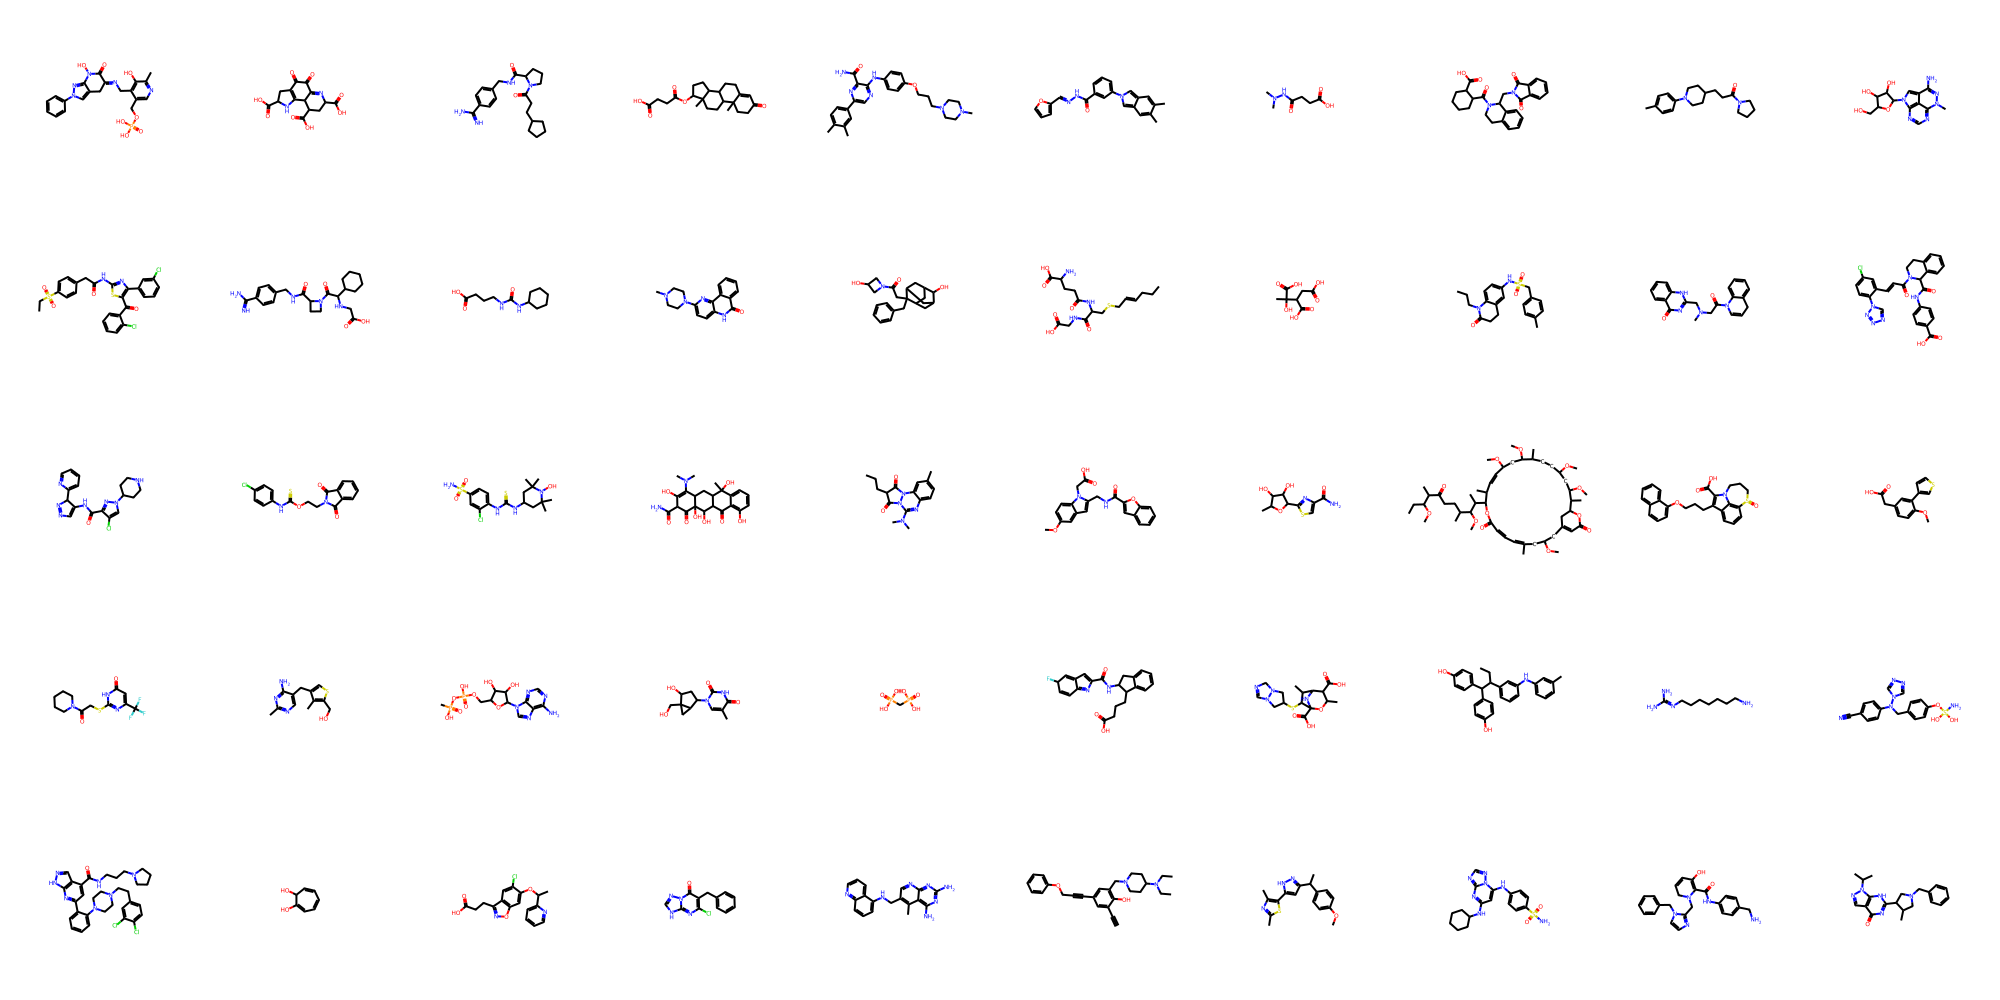

In [75]:
# display molecules
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smiles[:100]], molsPerRow=10)